In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from enum import Enum
import itertools
import utility as util

In [2]:
# Setup and global variables
# --------------------------
# Set the path to the data directory
fig_dir = "img/"
# Plotting setup and style
viridis_cmap = plt.get_cmap("viridis")
plasma_cmap = plt.get_cmap("plasma")
inferno_cmap = plt.get_cmap("inferno")
magma_cmap = plt.get_cmap("magma")

sns.set_style("darkgrid")
# Relative data paths
output_energy = "output-energy" # Energy measurement output file
output_timing = "output-timing" # Timing measurement output file
s_hardware = "-hardware"
s_software = "-software"
s_full = "-full"

(0.0, 10.0, 0.0, 1.0)

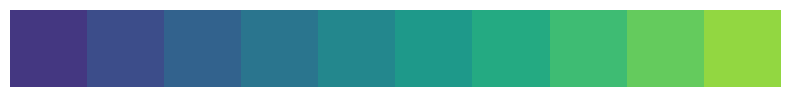

In [3]:
# Test util.get_colors_from_cmap
colors = util.get_colors_from_cmap(10, viridis_cmap)
# Plot the colors with a square each
fig, ax = plt.subplots(figsize=(10, 1))
ax.imshow([colors], extent=[0, 10, 0, 1])
ax.axis("off")

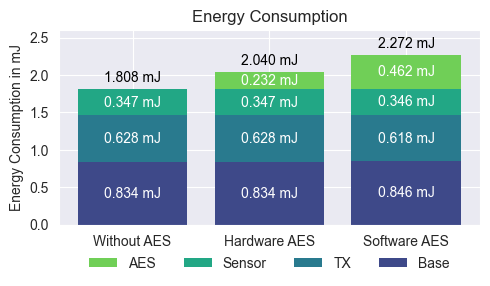

In [22]:
# Hardware numbers
# ----------------

# -> Full hardware energy consumption <-
energy_full_hardware = util.Measurements(energy_output=(output_energy + s_full + s_hardware + ".txt", util.OutputType.ENERGY_FULL))

hardware_df_dict_full = energy_full_hardware.get_dfs()


# -> Fragmented hardware energy consumption <-
measurements_hardware = util.Measurements(
    energy_output = (output_energy + s_hardware + ".txt", util.OutputType.ENERGY),
    timing_output = (output_timing + s_hardware + ".txt", util.OutputType.TIMING)
)

hardware_df_dict = measurements_hardware.get_dfs()

mJ_hardware_means = {
    "full": hardware_df_dict_full["Energy state"]["energy_mJ"].mean(),
    "Sensor": hardware_df_dict["Energy state"]["Sensor"]["energy_mJ"].mean(),
    "AES": hardware_df_dict["Energy state"]["AES"]["energy_mJ"].mean(),
    "TX": hardware_df_dict["Energy state"]["TX"]["energy_mJ"].mean()
}

mJ_hardware_means

# Software numbers
# ----------------

# -> Full software energy consumption <-
energy_full_software = util.Measurements(energy_output=(output_energy + s_full + s_software + ".txt", util.OutputType.ENERGY_FULL))

software_df_dict_full = energy_full_software.get_dfs()


# -> Fragmented software energy consumption <-
measurements_software = util.Measurements(
    energy_output = (output_energy + s_software + ".txt", util.OutputType.ENERGY),
    timing_output = (output_timing + s_software + ".txt", util.OutputType.TIMING)
)

software_df_dict = measurements_software.get_dfs()

mJ_software_means = {
    "full": software_df_dict_full["Energy state"]["energy_mJ"].mean(),
    "Sensor": software_df_dict["Energy state"]["Sensor"]["energy_mJ"].mean(),
    "AES": software_df_dict["Energy state"]["AES"]["energy_mJ"].mean(),
    "TX": software_df_dict["Energy state"]["TX"]["energy_mJ"].mean()
}

mJ_software_means

# -> Plotting energy consumption <-
# plot the energy consumption in a bar plot
# plot the base energy consumption as `full - sensor - aes - tx`
# plot the tx energy consumption as `tx`, starting at the base
# plot the sensor energy consumption as `sensor`, starting at the base + tx
# plot the aes energy consumption as `aes`, starting at the base + tx + sensor

cols = util.get_colors_from_cmap(4, viridis_cmap)
text_offset = - 0.001
top_offset = 0.15

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# -> Plotting wihtout AES energy consumption <-
base_hardware_consumption = mJ_hardware_means["full"] - mJ_hardware_means["Sensor"] - mJ_hardware_means["TX"] - mJ_hardware_means["AES"]
ax.bar(["Without AES"], [mJ_hardware_means["Sensor"]], bottom=base_hardware_consumption + mJ_hardware_means["TX"], color=cols[2], edgecolor="none")
ax.bar(["Without AES"], [mJ_hardware_means["TX"]], bottom=base_hardware_consumption, color=cols[1], edgecolor="none")
ax.bar(["Without AES"], [base_hardware_consumption], color=cols[0], edgecolor="none")
# -> Plotting hardware energy consumption labels in center of each bar segment <-
ax.text(0, base_hardware_consumption / 2 + text_offset, f"{base_hardware_consumption:.3f} mJ", ha="center", va="center", color="white")
ax.text(0, base_hardware_consumption + mJ_hardware_means["TX"] / 2 + text_offset, f"{mJ_hardware_means['TX']:.3f} mJ", ha="center", va="center", color="white")
ax.text(0, base_hardware_consumption + mJ_hardware_means["TX"] + mJ_hardware_means["Sensor"] / 2 + text_offset, f"{mJ_hardware_means['Sensor']:.3f} mJ", ha="center", va="center", color="white")
# -> Plotting total value on top of bar <-
total_val = mJ_hardware_means['full'] - mJ_hardware_means["AES"]
ax.text(0, mJ_hardware_means["full"] - mJ_hardware_means["AES"] + text_offset + top_offset, f"{total_val:.3f} mJ", ha="center", va="center", color="black")


# -> Plotting hardware energy consumption <-
base_hardware_consumption = mJ_hardware_means["full"] - mJ_hardware_means["Sensor"] - mJ_hardware_means["AES"] - mJ_hardware_means["TX"]
ax.bar(["Hardware AES"], [mJ_hardware_means["AES"]], bottom=base_hardware_consumption + mJ_hardware_means["Sensor"] + mJ_hardware_means["TX"], label="AES", color=cols[3], edgecolor="none")
ax.bar(["Hardware AES"], [mJ_hardware_means["Sensor"]], bottom=base_hardware_consumption + mJ_hardware_means["TX"], label="Sensor", color=cols[2], edgecolor="none")
ax.bar(["Hardware AES"], [mJ_hardware_means["TX"]], bottom=base_hardware_consumption, label="TX", color=cols[1], edgecolor="none")
ax.bar(["Hardware AES"], [base_hardware_consumption], label="Base", color=cols[0], edgecolor="none")
# -> Plotting hardware energy consumption labels in center of each bar segment <-
ax.text(1, base_hardware_consumption / 2 + text_offset, f"{base_hardware_consumption:.3f} mJ", ha="center", va="center", color="white")
ax.text(1, base_hardware_consumption + mJ_hardware_means["TX"] / 2 + text_offset, f"{mJ_hardware_means['TX']:.3f} mJ", ha="center", va="center", color="white")
ax.text(1, base_hardware_consumption + mJ_hardware_means["TX"] + mJ_hardware_means["Sensor"] / 2 + text_offset, f"{mJ_hardware_means['Sensor']:.3f} mJ", ha="center", va="center", color="white")
ax.text(1, base_hardware_consumption + mJ_hardware_means["TX"] + mJ_hardware_means["Sensor"] + mJ_hardware_means["AES"] / 2 + text_offset, f"{mJ_hardware_means['AES']:.3f} mJ", ha="center", va="center", color="white")
# -> Plotting total value on top of bar <-
ax.text(1, mJ_hardware_means["full"] + text_offset + top_offset, f"{mJ_hardware_means['full']:.3f} mJ", ha="center", va="center", color="black")

ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.5, -0.1), frameon=False)
# -> Plotting software energy consumption <-
base_software_consumption = mJ_software_means["full"] - mJ_software_means["Sensor"] - mJ_software_means["AES"] - mJ_software_means["TX"]
ax.bar(["Software AES"], [mJ_software_means["AES"]], bottom=base_software_consumption + mJ_software_means["Sensor"] + mJ_software_means["TX"], color=cols[3], edgecolor="none")
ax.bar(["Software AES"], [mJ_software_means["Sensor"]], bottom=base_software_consumption + mJ_software_means["TX"], color=cols[2], edgecolor="none")
ax.bar(["Software AES"], [mJ_software_means["TX"]], bottom=base_software_consumption, color=cols[1], edgecolor="none")
ax.bar(["Software AES"], [base_software_consumption], color=cols[0], edgecolor="none")
# -> Plotting software energy consumption labels in center of each bar segment <-
ax.text(2, base_software_consumption / 2 + text_offset, f"{base_software_consumption:.3f} mJ", ha="center", va="center", color="white")
ax.text(2, base_software_consumption + mJ_software_means["TX"] / 2 + text_offset, f"{mJ_software_means['TX']:.3f} mJ", ha="center", va="center", color="white")
ax.text(2, base_software_consumption + mJ_software_means["TX"] + mJ_software_means["Sensor"] / 2 + text_offset, f"{mJ_software_means['Sensor']:.3f} mJ", ha="center", va="center", color="white")
ax.text(2, base_software_consumption + mJ_software_means["TX"] + mJ_software_means["Sensor"] + mJ_software_means["AES"] / 2 + text_offset, f"{mJ_software_means['AES']:.3f} mJ", ha="center", va="center", color="white")
# -> Plotting total value on top of bar <-
ax.text(2, mJ_software_means["full"] + text_offset + top_offset, f"{mJ_software_means['full']:.3f} mJ", ha="center", va="center", color="black")

ax.set_title("Energy Consumption")
ax.set_ylabel("Energy Consumption in mJ")

ax.set_ylim(0, 2.6)

fig.tight_layout()

# save the figure both as pdf and png at dpi 300
fig.savefig(fig_dir + "pdf/energy_consumption.pdf")
fig.savefig(fig_dir + "png/energy_consumption.png", dpi=300)

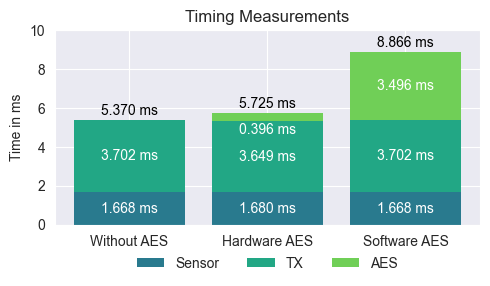

In [21]:
# Hardware timing measurements
# ---------------------------

# -> Hardware AES timing <-
timing_hardware = util.Measurements(timing_output=(output_timing + s_hardware + ".txt", util.OutputType.TIMING))

# -> Software AES timing <-
timing_software = util.Measurements(timing_output=(output_timing + s_software + ".txt", util.OutputType.TIMING))

software_df = timing_hardware.get_dfs()["Timings"]
hardware_df = timing_software.get_dfs()["Timings"]

aes_timing_means = {
    "Hardware": software_df["AES Encryption"].mean() / util.Measurements.TICKS_PER_SECOND * 1000,
    "Software": hardware_df["AES Encryption"].mean() / util.Measurements.TICKS_PER_SECOND * 1000,
}

tx_timing_means = {
    "Hardware": software_df["TX"].mean() / util.Measurements.TICKS_PER_SECOND * 1000,
    "Software": hardware_df["TX"].mean() / util.Measurements.TICKS_PER_SECOND * 1000,
}

sensor_timing_means = {
    "Hardware": software_df["Sensor"].mean() / util.Measurements.TICKS_PER_SECOND * 1000,
    "Software": hardware_df["Sensor"].mean() / util.Measurements.TICKS_PER_SECOND * 1000,
}


# -> Plotting timing measurements <-
# plot the timing measurements in a bar chart
# plot in segments with Sensor, TX, AES

# cols = util.get_colors_from_cmap(3, viridis_cmap)
# text_offset = - 0.001
top_offset = 0.5

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# -> Plotting without aes timing <-
ax.bar(["Without AES"], [sensor_timing_means["Software"]], color=cols[1], edgecolor="none")
ax.bar(["Without AES"], [tx_timing_means["Software"]], bottom=sensor_timing_means["Software"], color=cols[2], edgecolor="none")
# -> Plotting without aes timing labels in center of each bar segment <-
ax.text(0, sensor_timing_means["Software"] / 2 + text_offset, f"{sensor_timing_means['Software']:.3f} ms", ha="center", va="center", color="white")
ax.text(0, sensor_timing_means["Software"] + tx_timing_means["Software"] / 2 + text_offset, f"{tx_timing_means['Software']:.3f} ms", ha="center", va="center", color="white")
# -> Plotting total value on top of bar <-
ax.text(0, sensor_timing_means["Software"] + tx_timing_means["Software"] + text_offset + top_offset, f"{sensor_timing_means['Software'] + tx_timing_means['Software']:.3f} ms", ha="center", va="center", color="black")

# -> Plotting hardware timing <-
ax.bar(["Hardware AES"], [sensor_timing_means["Hardware"]], label="Sensor", color=cols[1], edgecolor="none")
ax.bar(["Hardware AES"], [tx_timing_means["Hardware"]], bottom=sensor_timing_means["Hardware"], label="TX", color=cols[2], edgecolor="none")
ax.bar(["Hardware AES"], [aes_timing_means["Hardware"]], bottom=sensor_timing_means["Hardware"] + tx_timing_means["Hardware"], label="AES", color=cols[3], edgecolor="none")
# -> Plotting hardware timing labels in center of each bar segment <-
ax.text(1, sensor_timing_means["Hardware"] / 2 + text_offset, f"{sensor_timing_means['Hardware']:.3f} ms", ha="center", va="center", color="white")
ax.text(1, sensor_timing_means["Hardware"] + tx_timing_means["Hardware"] / 2 + text_offset, f"{tx_timing_means['Hardware']:.3f} ms", ha="center", va="center", color="white")
ax.text(1, sensor_timing_means["Hardware"] + tx_timing_means["Hardware"] + aes_timing_means["Hardware"] / 2 + text_offset - 0.65, f"{aes_timing_means['Hardware']:.3f} ms", ha="center", va="center", color="white")
# -> Plotting total value on top of bar <-
ax.text(1, sensor_timing_means["Hardware"] + tx_timing_means["Hardware"] + aes_timing_means["Hardware"] + text_offset + top_offset, f"{sensor_timing_means['Hardware'] + tx_timing_means['Hardware'] + aes_timing_means['Hardware']:.3f} ms", ha="center", va="center", color="black")

ax.legend(ncol=3, loc="upper center", bbox_to_anchor=(0.5, -0.1), frameon=False)

# -> Plotting software timing <-
ax.bar(["Software AES"], [sensor_timing_means["Software"]], color=cols[1], edgecolor="none")
ax.bar(["Software AES"], [tx_timing_means["Software"]], bottom=sensor_timing_means["Software"], color=cols[2], edgecolor="none")
ax.bar(["Software AES"], [aes_timing_means["Software"]], bottom=sensor_timing_means["Software"] + tx_timing_means["Software"], color=cols[3], edgecolor="none")
# -> Plotting software timing labels in center of each bar segment <-
ax.text(2, sensor_timing_means["Software"] / 2 + text_offset, f"{sensor_timing_means['Software']:.3f} ms", ha="center", va="center", color="white")
ax.text(2, sensor_timing_means["Software"] + tx_timing_means["Software"] / 2 + text_offset, f"{tx_timing_means['Software']:.3f} ms", ha="center", va="center", color="white")
ax.text(2, sensor_timing_means["Software"] + tx_timing_means["Software"] + aes_timing_means["Software"] / 2 + text_offset, f"{aes_timing_means['Software']:.3f} ms", ha="center", va="center", color="white")
# -> Plotting total value on top of bar <-
ax.text(2, sensor_timing_means["Software"] + tx_timing_means["Software"] + aes_timing_means["Software"] + text_offset + top_offset, f"{sensor_timing_means['Software'] + tx_timing_means['Software'] + aes_timing_means['Software']:.3f} ms", ha="center", va="center", color="black")

ax.set_title("Timing Measurements")
ax.set_ylabel("Time in ms")

ax.set_ylim(0, 10)

fig.tight_layout()

# save the figure both as pdf and png at dpi 300
fig.savefig(fig_dir + "pdf/timing_measurements.pdf")
fig.savefig(fig_dir + "png/timing_measurements.png", dpi=300)

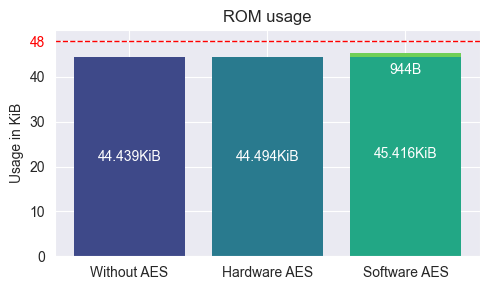

In [23]:
# there is 48KiB of ROM
total_space_bytes = 48 * 1024
no_aes_bytes = 45506
hardware_aes_bytes = 45562
software_aes_bytes = 46506

# plot as a bar chart
# KiB unit on y axis
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.bar(
    ["Without AES", "Hardware AES", "Software AES"],
    [no_aes_bytes / 1024, hardware_aes_bytes / 1024, software_aes_bytes / 1024],
    color=[cols[0], cols[1], cols[2]], edgecolor="none"
)
ax.set_ylabel("Usage in KiB")
ax.set_title("ROM usage")
# print the value for Software and Hardware AES on the bar
for i, v in enumerate([no_aes_bytes / 1024, hardware_aes_bytes / 1024, software_aes_bytes / 1024]):
    ax.text(i, v/2, f"{v:.3f}KiB", ha="center", va="center", color="white")

# the ticks
limit_color = "red"
ax.axhline(y=total_space_bytes / 1024, color=limit_color, linestyle="--", linewidth=1)
ax.set_yticks(list(range(0, 50, 10)) + [total_space_bytes / 1024])
ax.get_yticklabels()[-1].set_color(limit_color)

# show difference using hardware AES as baseline, using a different color for the diff bar
diff = software_aes_bytes - hardware_aes_bytes
diff_color = cols[3]
ax.bar(["Software AES"], [diff / 1024], bottom=hardware_aes_bytes / 1024, color=diff_color, edgecolor="none")
# print the value for the diff on the bar in red
ax.text(2, (hardware_aes_bytes / 1024)-3, f"{diff:.0f}B", ha="center", va="center", color="white")

fig.tight_layout()

# save the figure as pdf and png
fig.savefig(fig_dir + "pdf/rom_usage.pdf")
fig.savefig(fig_dir + "png/rom_usage.png", dpi=300)

plt.show()